In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.datasets import load_linnerud
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion
from physlearn import Regressor

# Загрузка данных

In [2]:
# Загрузим данные. Я их немножно подправил ещё до загрузки.
df = pd.read_excel("data/data_00.xlsx")

# Уберём ненужные столбцы и пустые значения
df = df.drop(columns=["Номер образца", "Адсорбент"]).dropna()

# Ещё один нюанс
df = df[df["Sme, м2/г"] != "-"]

# Сменим тип данных у таблицы
df["Sme, м2/г"] = df["Sme, м2/г"].astype(np.float64, copy=False)
df["m (соли), г"] = df["m (соли), г"].astype(np.float64, copy=False)
df["Vпр. (р-ля), мл"] = df["Vпр. (р-ля), мл"].astype(np.float64, copy=False)

# У нас есть 3 категориальных признака, которых мы закодируем числами
list_of_cats = ["Металл", "Лиганд", "Растворитель"]
cat2id = {cat:{v:i for i, v in enumerate(df[cat].drop_duplicates().values)} for cat in list_of_cats}
id2cat = {cat:{i:v for i, v in enumerate(df[cat].drop_duplicates().values)} for cat in list_of_cats}
for cat in list_of_cats:
    df[cat] = df[cat].apply(lambda x: cat2id[cat][x])

Нужно предсказать:
* 'Tрег, ᵒС\n'
* 'Металл', 
* 'Лиганд', 
* 'Растворитель', 
* 'm (соли), г', 
* 'm(кис-ты), г',
* 'Vсин. (р-ля), мл', 
* 'Т.син., °С', 
* 'Vпр. (р-ля), мл', 
* 'Т суш., °С',


Подадите на вход:
* 'W0, см3/г'
* 'SБЭТ, м2/г'

In [3]:
# Кусок кода взят отсюда: https://scikit-physlearn.readthedocs.io/en/latest/quick_start.html

bunch = load_linnerud(as_frame=True)  # returns a Bunch instance

In [4]:
X_cols = ['W0, см3/г', 'SБЭТ, м2/г']

In [5]:
y_cols = ['Tрег, ᵒС\n', 'Металл', 'Лиганд', 'Растворитель', 'm (соли), г', 'm(кис-ты), г', 'Vсин. (р-ля), мл', 'Т.син., °С', 'Vпр. (р-ля), мл', 'Т суш., °С']

In [6]:
X = df[X_cols]

In [7]:
y = df[y_cols]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42)

transformer_list = [('pca', PCA(n_components=1)),
                    ('svd', TruncatedSVD(n_components=2))]
union = FeatureUnion(transformer_list=transformer_list, n_jobs=-1)

# Select a regressor, e.g., LGBMRegressor from LightGBM,
# with a case-insensitive string.
reg = Regressor(regressor_choice='lgbmregressor',
                pipeline_transform=('tr', union),
                scoring='neg_mean_absolute_error')

# Automatically build the pipeline with final estimator MultiOutputRegressor
# from Sklearn, then exhaustively search over the (hyper)parameters.
search_params = dict(reg__boosting_type=['gbdt', 'goss'],
                     reg__n_estimators=[6, 8, 10, 20])
reg.search(X_train, y_train, search_params=search_params,
           search_method='gridsearchcv')

# Generate predictions with the refit regressor, then
# compute the average mean absolute error.
y_pred = reg.fit(X_train, y_train).predict(X_test)
score = reg.score(y_test, y_pred)
print(score['mae'].mean().round(decimals=2))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[Pipeline] ................ (step 1 of 2) Processing tr, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing reg, total=   0.1s
[Pipeline] ................ (step 1 of 2) Processing tr, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing reg, total=   0.0s
16.17


In [9]:
INPUT = [0.5, 1500]
output = reg.predict(pd.DataFrame([INPUT], columns=X_test.columns))
output.columns = y_cols
# Раскодируем наши категориальные признаки
for cat in list_of_cats:
    output.loc[0, cat] = id2cat[cat][round(output.loc[0, cat])]
output

,"Tрег, ᵒС\n",Металл,Лиганд,Растворитель,"m (соли), г","m(кис-ты), г","Vсин. (р-ля), мл","Т.син., °С","Vпр. (р-ля), мл","Т суш., °С"
0,132.497035,Fe,NH2-BDC,ДМФА,1.687657,1.039042,40.844399,129.295022,208.285943,126.929446


In [10]:
INPUT = X_test.iloc[0,:].values
output = reg.predict(pd.DataFrame([INPUT], columns=X_test.columns))
pred = output.values[0]
output.columns = y_cols
# Раскодируем наши категориальные признаки
for cat in list_of_cats:
    output.loc[0, cat] = id2cat[cat][round(output.loc[0, cat])]
output

,"Tрег, ᵒС\n",Металл,Лиганд,Растворитель,"m (соли), г","m(кис-ты), г","Vсин. (р-ля), мл","Т.син., °С","Vпр. (р-ля), мл","Т суш., °С"
0,172.967609,Ti,NH2-BDC,ДМФА,4.399951,2.297097,57.860274,121.832602,266.423665,126.480035


In [11]:
pred

array([1.72967609e+02, 2.58643142e+00, 6.39489196e-01, 7.76438751e-02,
       4.39995091e+00, 2.29709667e+00, 5.78602742e+01, 1.21832602e+02,
       2.66423665e+02, 1.26480035e+02])

In [12]:
y_test.iloc[0,:]

Tрег, ᵒС\n          110.0000
Металл                2.0000
Лиганд                3.0000
Растворитель          0.0000
m (соли), г           0.3560
m(кис-ты), г          0.3505
Vсин. (р-ля), мл     64.0000
Т.син., °С          110.0000
Vпр. (р-ля), мл     150.0000
Т суш., °С          130.0000
Name: 236, dtype: float64

### Предложение по метрике: 
## Ненормализованния (до построения следующего алгоритма) суммарная средне-взвешенная ошибка

Важность предсказаний

* Металл  0%
* Лиганд  1%
* Растворитель 2%
* m (соли), г 3%
* m(кис-ты), г 3%
* Vсин. (р-ля), мл  5%
* Т.син., °С 1%
* Vпр. (р-ля), мл 10%
* Т суш., °С 5%
* Tрег, ᵒС (10%)

In [13]:
for col_name, value in zip(y_test.columns, y_test.iloc[0,:]):
    col_name = col_name.replace("\n", "")
    print(col_name, value)

Tрег, ᵒС 110.0
Металл 2.0
Лиганд 3.0
Растворитель 0.0
m (соли), г 0.356
m(кис-ты), г 0.3505
Vсин. (р-ля), мл 64.0
Т.син., °С 110.0
Vпр. (р-ля), мл 150.0
Т суш., °С 130.0


In [14]:
list_of_cols = [i.replace("\n", "") for i in y_test.columns]

In [15]:
list_of_allowed_err = [10, 0, 1, 2, 3, 3, 5, 1, 10, 5]

In [16]:
list_of_importancy = [(abs(10 - i) + 5) / 110 for i in list_of_allowed_err]

In [17]:
err_weights = {k:v for k,v in zip(list_of_cols, list_of_importancy)}

In [18]:
true = y_test.iloc[0,:].values

In [19]:
sum(abs(true - pred) * np.array(list_of_importancy))

11.581356995739153

Напишем функцию

In [20]:
def USWE(true, pred):
    list_of_allowed_err = [10, 0, 1, 2, 3, 3, 5, 1, 10, 5]
    list_of_importancy = [(abs(10 - i) + 5) / 110 for i in list_of_allowed_err]
    return sum(abs(true - pred) * np.array(list_of_importancy))

In [21]:
print(USWE(true, pred))

11.581356995739153


Посчитаем для всех предсказаний

In [22]:
output = reg.predict(pd.DataFrame(X_test, columns=X_test.columns))

In [23]:
preds = output.values

In [24]:
trues = y_test.values

In [25]:
MUSWE = 0
for pred, true in zip(preds, trues):
    MUSWE += USWE(true, pred)
MUSWE /= len(preds)
print(MUSWE)

9.893013432041322


Средняя ошибка составила 9.89.
Попробуем улучшить этот показатель

# Нормализация

Номамилизацию сделаем от 0 до 1

In [26]:
# Загрузим данные. Я их немножно подправил ещё до загрузки.
df = pd.read_excel("data/data_00.xlsx")

# Уберём ненужные столбцы и пустые значения
df = df.drop(columns=["Номер образца", "Адсорбент"]).dropna()

# Ещё один нюанс
df = df[df["Sme, м2/г"] != "-"]

# Сменим тип данных у таблицы
df["Sme, м2/г"] = df["Sme, м2/г"].astype(np.float64, copy=False)
df["m (соли), г"] = df["m (соли), г"].astype(np.float64, copy=False)
df["Vпр. (р-ля), мл"] = df["Vпр. (р-ля), мл"].astype(np.float64, copy=False)

# У нас есть 3 категориальных признака, которых мы закодируем числами
list_of_cats = ["Металл", "Лиганд", "Растворитель"]
cat2id = {cat:{v:i for i, v in enumerate(df[cat].drop_duplicates().values)} for cat in list_of_cats}
id2cat = {cat:{i:v for i, v in enumerate(df[cat].drop_duplicates().values)} for cat in list_of_cats}
for cat in list_of_cats:
    df[cat] = df[cat].apply(lambda x: cat2id[cat][x])

In [27]:
cols = list(df.columns)

In [28]:
normalization_weights = {}
for col in cols:
    min_ = df.loc[:,col].min()
    max_ = df.loc[:,col].max()
    normalization_weights[col] = min_, max_

Нули в значениях могут помешать при подсчёте некоторых метрик, так что отнормируем от 0.01 до 1.01

In [29]:
def normalize(value, col):
    min_, max_ = normalization_weights[col]
    z_value = (value - min_) / (max_ - min_)
    return z_value + 0.01

In [30]:
for col in cols:
    df.loc[:,col] = df.loc[:,col].apply(lambda value: normalize(value, col))

In [31]:
def restore_normalization(z_value, col):
    min_, max_ = normalization_weights[col]
    value = (z_value - 0.01) * (max_ - min_) + min_
    return value

In [32]:
X = df[X_cols]
y = df[y_cols]


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42)

transformer_list = [('pca', PCA(n_components=1)),
                    ('svd', TruncatedSVD(n_components=2))]
union = FeatureUnion(transformer_list=transformer_list, n_jobs=-1)

# Select a regressor, e.g., LGBMRegressor from LightGBM,
# with a case-insensitive string.
reg = Regressor(regressor_choice='lgbmregressor',
                pipeline_transform=('tr', union),
                scoring='neg_mean_absolute_error')

# Automatically build the pipeline with final estimator MultiOutputRegressor
# from Sklearn, then exhaustively search over the (hyper)parameters.
search_params = dict(reg__boosting_type=['gbdt', 'goss'],
                     reg__n_estimators=[6, 8, 10, 20])
reg.search(X_train, y_train, search_params=search_params,
           search_method='gridsearchcv')

# Generate predictions with the refit regressor, then
# compute the average mean absolute error.
y_pred = reg.fit(X_train, y_train).predict(X_test)
score = reg.score(y_test, y_pred)
print(score['mae'].mean().round(decimals=2))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[Pipeline] ................ (step 1 of 2) Processing tr, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing reg, total=   0.0s
[Pipeline] ................ (step 1 of 2) Processing tr, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing reg, total=   0.0s
0.13


In [33]:
output = reg.predict(pd.DataFrame(X_test, columns=X_test.columns))

In [34]:
preds = output.values
trues = y_test.values

In [35]:
def NSWE(true, pred):
    list_of_allowed_err = [10, 0, 1, 2, 3, 3, 5, 1, 10, 5]
    list_of_importancy = [(abs(10 - i) + 5) / 110 for i in list_of_allowed_err]
    return sum(abs(true - pred) * np.array(list_of_importancy))

In [36]:
MNSWE = 0
for pred, true in zip(preds, trues):
    MNSWE += NSWE(true, pred)
MNSWE /= len(preds)
print(MNSWE)

0.1376766272377534


Средняя нормализованная суммарная взвещенная ошибка составила 14%

In [37]:
preds = pd.DataFrame(preds, columns=y_test.columns)

In [38]:
for col in preds.columns:
    preds.loc[:,col] = preds.loc[:,col].apply(lambda value: restore_normalization(value, col))
    y_test.loc[:,col] = y_test.loc[:,col].apply(lambda value: restore_normalization(value, col))

In [39]:
preds = preds.values
trues = y_test.values

MUSWE = 0
for pred, true in zip(preds, trues):
    MUSWE += USWE(true, pred)
MUSWE /= len(preds)
print(MUSWE)

9.769727360287982


In [40]:
preds = pd.DataFrame(preds, columns=y_test.columns)

# Раскодируем наши категориальные признаки
for i in range(preds.shape[0]):
    for cat in list_of_cats:
        preds.loc[i, cat] = id2cat[cat][round(preds.loc[i, cat])]

y_test.reset_index(inplace=True)

y_test.drop(columns="index", inplace=True)

# Раскодируем наши категориальные признаки
for i in range(y_test.shape[0]):
    for cat in list_of_cats:
        y_test.loc[i, cat] = id2cat[cat][round(y_test.loc[i, cat])]

for col in X_test.columns:
    X_test.loc[:,col] = X_test.loc[:,col].apply(lambda value: restore_normalization(value, col))


In [41]:
X_test.head()

,"W0, см3/г","SБЭТ, м2/г"
236,0.66,1516.0
9,0.42,1208.7
57,0.76,1987.6
60,0.39,1014.1
25,0.37,1030.4


In [42]:
preds.head()

,"Tрег, ᵒС\n",Металл,Лиганд,Растворитель,"m (соли), г","m(кис-ты), г","Vсин. (р-ля), мл","Т.син., °С","Vпр. (р-ля), мл","Т суш., °С"
0,167.339442,Ti,NH2-BDC,ДМФА,3.997244,2.208405,56.848841,121.774449,235.133346,127.754200
1,139.721516,Fe,NH2-BDC,ДМФА,1.250657,0.785442,38.134959,129.474008,162.681123,130.548723
2,181.065486,Fe,BDC,ДМФА,1.285941,0.706999,27.144168,125.359650,162.521746,120.892408
3,169.837742,Zn,NH2-BDC,ДМФА,3.096069,1.920837,63.407185,128.334471,219.677051,129.315583
4,146.481305,Fe,NH2-BDC,ДМФА,1.227420,0.785442,35.463340,128.030652,162.681123,130.548723


In [43]:
y_test.head()

,"Tрег, ᵒС\n",Металл,Лиганд,Растворитель,"m (соли), г","m(кис-ты), г","Vсин. (р-ля), мл","Т.син., °С","Vпр. (р-ля), мл","Т суш., °С"
0,110.0,Zn,BTB,ДМФА,0.3560,0.3505,64.0,110.0,150.0,130.0
1,130.0,Al,BTC,ДМФА,1.0740,0.4910,28.0,130.0,200.0,130.0
2,130.0,Fe,BDC,ДМФА,0.8050,0.4980,24.0,130.0,150.0,130.0
3,130.0,Fe,BDC,ДМФА,0.8092,0.5000,24.0,130.0,150.0,130.0
4,130.0,Al,BTC,ДМФА,1.0740,0.4910,28.0,130.0,150.0,100.0


## Вывод:
Нормализация помогла нам повысить точность предсказаний а также ввести новую метрику, которая точнее отражает важные показатели, такие как металлы и лиганды

# Используем примитивную нейросеть

In [44]:
# Загрузим данные. Я их немножно подправил ещё до загрузки.
df = pd.read_excel("data/data_00.xlsx")

# Уберём ненужные столбцы и пустые значения
df = df.drop(columns=["Номер образца", "Адсорбент"]).dropna()

# Ещё один нюанс
df = df[df["Sme, м2/г"] != "-"]

# Сменим тип данных у таблицы
df["Sme, м2/г"] = df["Sme, м2/г"].astype(np.float64, copy=False)
df["m (соли), г"] = df["m (соли), г"].astype(np.float64, copy=False)
df["Vпр. (р-ля), мл"] = df["Vпр. (р-ля), мл"].astype(np.float64, copy=False)

# У нас есть 3 категориальных признака, которых мы закодируем числами
list_of_cats = ["Металл", "Лиганд", "Растворитель"]
cat2id = {cat:{v:i for i, v in enumerate(df[cat].drop_duplicates().values)} for cat in list_of_cats}
id2cat = {cat:{i:v for i, v in enumerate(df[cat].drop_duplicates().values)} for cat in list_of_cats}
for cat in list_of_cats:
    df[cat] = df[cat].apply(lambda x: cat2id[cat][x])

cols = list(df.columns)
normalization_weights = {}
for col in cols:
    min_ = df.loc[:,col].min()
    max_ = df.loc[:,col].max()
    normalization_weights[col] = min_, max_
    
def normalize(value, col):
    min_, max_ = normalization_weights[col]
    z_value = (value - min_) / (max_ - min_)
    return z_value + 0.01

for col in cols:
    df.loc[:,col] = df.loc[:,col].apply(lambda value: normalize(value, col))

def restore_normalization(z_value, col):
    min_, max_ = normalization_weights[col]
    value = (z_value - 0.01) * (max_ - min_) + min_
    return value

X = df[X_cols]
y = df[y_cols]


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42)

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [46]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 120)
        self.fc2 = nn.Linear(120, 120)
        self.fc3 = nn.Linear(120, 120)
        self.fc4 = nn.Linear(120, 120)
        self.fc5 = nn.Linear(120, 120)
        self.fc6 = nn.Linear(120, 84)
        self.fc7 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = self.fc7(x)
        return x

In [47]:
from torch.utils.data import Dataset, DataLoader

# Convert data to torch tensors
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return self.X[index], self.y[index]
   
    def __len__(self):
        return self.len


batch_size = 64

# Instantiate training and test data
train_data = Data(X_train.values, y_train.values)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

test_data = Data(X_test.values, y_test.values)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

# Check it's working
for batch, (X, y) in enumerate(train_dataloader):
    print(f"Batch: {batch+1}")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    break


"""
Batch: 1
X shape: torch.Size([64, 2])
y shape: torch.Size([64])
"""

Batch: 1
X shape: torch.Size([64, 2])
y shape: torch.Size([64, 10])


'\nBatch: 1\nX shape: torch.Size([64, 2])\ny shape: torch.Size([64])\n'

In [48]:
model = Net()

In [49]:
loss_fn = nn.MSELoss()

In [50]:
from tqdm import tqdm

In [51]:
import torch.optim as optim

In [52]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [53]:
num_epochs = 1000
loss_values = []


for epoch in tqdm(range(num_epochs)):
    for X, y in train_dataloader:
        # zero the parameter gradients
        optimizer.zero_grad()
       
        # forward + backward + optimize
        pred = model(X)
        loss = loss_fn(pred, y.unsqueeze(-1)[:,:,0])
        loss_values.append(loss.item())
        loss.backward()
        optimizer.step()

print("Training Complete")

"""
Training Complete
"""

100%|██████████| 1000/1000 [00:05<00:00, 171.26it/s]

Training Complete


'\nTraining Complete\n'

In [54]:
from matplotlib import pyplot as plt

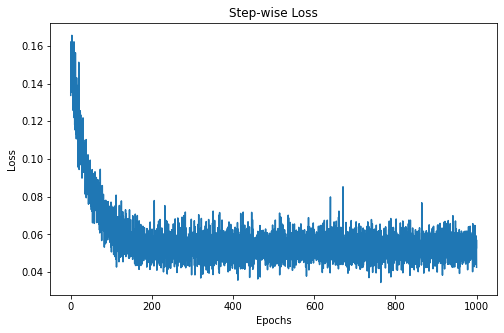

In [55]:
step = np.linspace(0, num_epochs, 4*num_epochs)

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, np.array(loss_values))
plt.title("Step-wise Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [56]:
preds = []
for input_ in X_test.values:
    preds.append([float(t) for t in model(torch.tensor([input_[0], input_[1]]).float())])

In [57]:
preds = np.array(preds)

In [58]:
trues = y_test.values

In [59]:
MNSWE = 0
for pred, true in zip(preds, trues):
    MNSWE += NSWE(true, pred)
MNSWE /= len(preds)
print(MNSWE)

0.17354938653878618


Использование полносвязной нейросети ухудшило нашу метрику. Она стала 17%

In [60]:
preds = pd.DataFrame(preds)

In [61]:
preds.columns = y_test.columns

In [62]:
for col in y_test.columns:
    preds.loc[:,col] = preds.loc[:,col].apply(lambda value: restore_normalization(value, col))
    y_test.loc[:,col] = y_test.loc[:,col].apply(lambda value: restore_normalization(value, col))

In [63]:
preds = pd.DataFrame(preds, columns=y_test.columns)

# Раскодируем наши категориальные признаки
for i in range(preds.shape[0]):
    for cat in list_of_cats:
        preds.loc[i, cat] = id2cat[cat][round(preds.loc[i, cat])]

y_test.reset_index(inplace=True)

y_test.drop(columns="index", inplace=True)

# Раскодируем наши категориальные признаки
for i in range(y_test.shape[0]):
    for cat in list_of_cats:
        y_test.loc[i, cat] = id2cat[cat][round(y_test.loc[i, cat])]

for col in X_test.columns:
    X_test.loc[:,col] = X_test.loc[:,col].apply(lambda value: restore_normalization(value, col))


In [64]:
y_test.head()

,"Tрег, ᵒС\n",Металл,Лиганд,Растворитель,"m (соли), г","m(кис-ты), г","Vсин. (р-ля), мл","Т.син., °С","Vпр. (р-ля), мл","Т суш., °С"
0,110.0,Zn,BTB,ДМФА,0.3560,0.3505,64.0,110.0,150.0,130.0
1,130.0,Al,BTC,ДМФА,1.0740,0.4910,28.0,130.0,200.0,130.0
2,130.0,Fe,BDC,ДМФА,0.8050,0.4980,24.0,130.0,150.0,130.0
3,130.0,Fe,BDC,ДМФА,0.8092,0.5000,24.0,130.0,150.0,130.0
4,130.0,Al,BTC,ДМФА,1.0740,0.4910,28.0,130.0,150.0,100.0


In [65]:
preds.head()

,"Tрег, ᵒС\n",Металл,Лиганд,Растворитель,"m (соли), г","m(кис-ты), г","Vсин. (р-ля), мл","Т.син., °С","Vпр. (р-ля), мл","Т суш., °С"
0,163.822497,Ti,NH2-BDC,ДМФА,3.087116,1.606259,46.921538,125.153446,207.475002,125.570900
1,163.957050,Ti,NH2-BDC,ДМФА,3.091141,1.604966,46.929894,125.183000,207.435478,125.604610
2,163.854731,Ti,NH2-BDC,ДМФА,3.086444,1.605435,46.869171,125.131223,207.196750,125.561648
3,163.932133,Ti,NH2-BDC,ДМФА,3.091452,1.605441,46.952785,125.190313,207.510534,125.601416
4,163.945982,Ti,NH2-BDC,ДМФА,3.092138,1.605340,46.944571,125.191887,207.517187,125.604191
